In [16]:
import os
import json
import math

import sys
sys.path.append("../utils")
from minimal_image import get_compact

from skimage.io import MultiImage

import matplotlib.pyplot as plt

import numpy as np

import cv2 as cv

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

In [17]:
with open("../input/compact_representation.json", "r") as file:
    compact_representation = json.load(file)

In [18]:
data_dir = "../input/prostate-cancer-grade-assessment/train_images/"
save_dir = "/datasets/panda/train_128_100"

tile_size = 128
num_tiles = 100

In [19]:
def tile(img, sz=128, N=16):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)

    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    
    img = img[idxs]
    s = int(np.sqrt(N))
    result = np.full([sz * s, sz * s, 3], 255, dtype=np.uint8)
    for i in range(len(img)):
        x = i % s
        y = i // s
        result[y * sz:(y + 1) * sz, x * sz:(x + 1) * sz] = img[i]
    
    return result

In [20]:
import matplotlib.pyplot as plt


class Data(Dataset):
    def __init__(self, compact, data_dir, tile_size, num_tiles, save_dir):
        self.compact = compact
        self.data_dir = data_dir
        self.keys = list(self.compact.keys())
        self.tile_size = tile_size
        self.num_tiles = num_tiles
        self.save_dir = save_dir

    def __len__(self):
        return len(compact_representation)

    def __getitem__(self, item):
        key = self.keys[item]
        item = self.compact[key]

        img = MultiImage(os.path.join(self.data_dir, key))[1]
        img = get_compact(img, item)
        img = tile(img, self.tile_size, self.num_tiles)

        save_path = os.path.join(self.save_dir, os.path.splitext(key)[0] + ".png")

        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        cv.imwrite(save_path, img)

        return item

In [21]:
os.makedirs(save_dir, exist_ok=True)

dataloader = DataLoader(Data(compact_representation, data_dir, tile_size, num_tiles, save_dir),
                       batch_size=12, num_workers=12)

for item in tqdm(dataloader):
    pass
    # img = MultiImage(os.path.join(data_dir, key))[1]
    # img = get_compact(img, item)
    # img = tile(img, tile_size, num_tiles)
    #
    # save_path = os.path.join(save_dir, os.path.splitext(key)[0] + ".png")
    #
    # img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    # cv.imwrite(save_path, img)

100%|██████████| 885/885 [13:29<00:00,  1.09it/s]


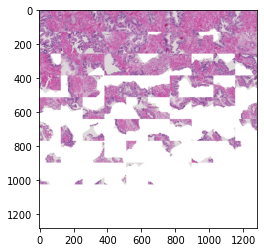

In [22]:
key = list(sorted(compact_representation.keys()))[1]
item = compact_representation[key]

img = MultiImage(os.path.join(data_dir, key))[1]
img = get_compact(img, item)
img = tile(img, tile_size, num_tiles)
plt.imshow(img)